6.804 Final Project II: Medical Bayes Net Structure Learning

Julie Vaughn

This is the primary accompanying notebook to my 6.804 project paper on Bayesian network structure preduction. I developed a particular noisy-OR bayesian network generator from Griffiths and Tenenbaum (2005), generate sample data from it, and then try to infer the structure again with statistical and human measures of causality. 

Disclaimer: stochastic elements of the program are generated using either pyro or numpy, with little regard for the optimal usage of pyro because I am not very familiar with pyro at all. Please let me know any optimizations you would suggest to better make use of pyro or make the code more efficient in general. 

Parts
(1) Medical Bayes Nets API 
(2) Data/graph generation with MBNs
(3) Structure estimation algorithm with MI
(4) Evaluation/results of algorithm  

In [202]:
import torch
import pyro
import pyro.distributions as dist
import numpy as np
from causalgraphicalmodels import CausalGraphicalModel

In [1238]:
#PART 1: MBN API
#define our Disease objects. These will be especially helpful
#for creating the vis application later on 
class Disease:
    def __init__(self, prior):
        self.prior = prior
        self.symptom_dict = {}
        self.severity = 0
        
    def sample_for_patient(self):
        disease = pyro.sample('disease', dist.Bernoulli(self.prior))
        return disease.item()
    
    def generate_random_sympt_dict(self, symptoms):
        for s in symptoms:
            #get weight values for each symptom, change below values if 
            #you want to put bounds on the values
            p_sym = pyro.sample('symptom', dist.Uniform(0,1)) 
            self.symptom_dict[s] = p_sym.item()
        return self.symptom_dict
            
            
    

In [204]:
#below function is incorporated into the class MedBayesNet below
def generate_med_bayes_net(num_diseases, num_symptoms):
    disease_list = []
    for d in range(num_diseases):
        d_prior = pyro.sample('d_prior', dist.Uniform(0,1))
        d = Disease(d_prior.item()) #new disease object
        
        #generate a random list of ints that correspond to symptoms out of all symptoms
        symptoms = np.random.choice(num_symptoms, np.random.randint(0, num_symptoms), replace= False)
        symptom_list = symptoms.tolist()
        symptom_list.sort()
        print(symptom_list)
        d.generate_random_sympt_dict(symptom_list)
        
        disease_list.append(d)
    return disease_list
        

In [205]:
diseases = generate_med_bayes_net(3, 5)
diseases[2].symptom_dict

[0, 2]
[0, 1, 2, 3]
[4]


{4: 0.8133533596992493}

In [595]:
#MedBayesNets are objects that encapsulate a set of symptoms, diseases
#and the causal links between them 

class MedBayesNet:
    def __init__(self, num_diseases, num_symptoms):
        self.num_diseases = num_diseases
        self.num_symptoms = num_symptoms
        
        disease_list = []
        for d in range(num_diseases):
            d_prior = pyro.sample('d_prior', dist.Uniform(0,1))
            d = Disease(d_prior.item()) #new disease object

            #generate a random list of ints that correspond to symptoms out of all symptoms
            try: 
                symptoms = np.random.choice(num_symptoms, np.random.randint(num_symptoms+1), replace= False)
                symptom_list = symptoms.tolist()
            except: #case when one of the params to np.random.choice was 0
                symptom_list = []
            symptom_list.sort()
            #print(symptom_list)
            d.generate_random_sympt_dict(symptom_list)

            disease_list.append(d)
        
        
        self.disease_list = disease_list
        
    def display_disease_connections(self):
        ind = 0 
        sym_list = []
        for d in self.disease_list:
            print(ind, d.symptom_dict)
            sym_list.append(d.symptom_dict)
            ind +=1
        return sym_list
            
    def display_disease_priors(self):
        d_list = []
        for d in self.disease_list:
            print(d.prior)
            d_list.append(d.prior)
        return d_list
            
    def get_graphics_object(self):
        #make a CausalGraphicalModel object that we can then call .draw() on
        d_strings = []
        s_strings = []
        connections = []
        #make string objects for nodes and edges
        for s in range(self.num_symptoms):
            s_str = "Symptom "+str(s)
            s_strings.append(s_str)
            
        for i in range(self.num_diseases):
            d_str = "Disease "+str(i)
            d_strings.append(d_str)
            for sym in self.disease_list[i].symptom_dict:
                tup = (d_str, s_strings[sym])
                connections.append(tup)
        #print(connections)
        #print(d_strings + s_strings)
        graphic = CausalGraphicalModel(
        nodes= d_strings + s_strings,
        edges= connections
            )
        
        
        return graphic
    
    def get_disease_object(self, index):
        return self.disease_list[index]
    
            
    
    #bayes sampling methods 
            
    def sample_diseases(self):
        dlist = []
        for d in self.disease_list:
            dlist.append(d.sample_for_patient())
        return dlist
    
    def simple_weighted_symp_sample(self, symptom, patient_list):
        #noisy_OR weighted sampling function
        ind = 0
        prob = 1
        for d in self.disease_list: 
            presence = patient_list[ind]
            if presence == 0.0:
                continue #skip rest of loop if you don't have the disease
            if symptom in d.symptom_dict:
                p = d.symptom_dict[symptom]
            else: 
                p = 0
            prob *= 1-p
            ind += 1
        #maybe find a way to store p_symptom in a patient class in the future
        p_symptom = 1-prob #bernoulli rv
        sym = pyro.sample('sym', dist.Bernoulli(p_symptom))
        return (sym.item(), p_symptom)

        
        
            
            
            
    


In [407]:
net_5_5 = MedBayesNet(5,5)
net_5_5.display_disease_connections()
net_5_5.display_disease_priors()
net_5_5.sample_diseases()

0 {}
1 {0: 0.10829275846481323}
2 {}
3 {1: 0.32552582025527954, 3: 0.46126270294189453}
4 {2: 0.13395071029663086, 3: 0.8290655016899109}
0.7092970609664917
0.5326727032661438
0.7009444832801819
0.914347767829895
0.3408252000808716


[1.0, 0.0, 1.0, 1.0, 1.0]

In [1239]:
#PART 2: SAMPLING
#sampling function
import tqdm #track progress
def sample_from_net(bayes_net, num):
    #num is the # of patients
    samples = []
    #ind = 0
    for ind in tqdm.tqdm(range(num)):
        patient_diseases = bayes_net.sample_diseases()
        
        patient_symptoms = []
        for symptom in range(bayes_net.num_symptoms):
            #can change which bayes_net sampling funct for symptom is used
            #if you want a more generalized bayes net
            presence, weight = bayes_net.simple_weighted_symp_sample(symptom, patient_diseases)
            #print(symptom, presence, weight)
            patient_symptoms.append(presence)
        patient = [patient_diseases, patient_symptoms]
        samples.append(patient)
        #print(patient)
        #ind += 1
    return samples

#samples are of the form [patient1, patient2, ... patient_num]
#where patient = [[disease_list],[symptom_list]]

        
    
            
            
            
            
            
        
        
        
        
        

In [560]:
simple_net = MedBayesNet(2,2)
simple_net.display_disease_connections()
simple_net.display_disease_priors()
sample_from_net(simple_net, 10)
#simple_net.get_graphics_object().draw()

100%|██████████| 10/10 [00:00<00:00, 6024.57it/s]

0 {}
1 {0: 0.6314746737480164}
0.22813111543655396
0.7014157176017761


[[[1.0, 1.0], [0.0, 0.0]],
 [[0.0, 1.0], [0.0, 0.0]],
 [[0.0, 0.0], [0.0, 0.0]],
 [[0.0, 1.0], [0.0, 0.0]],
 [[0.0, 0.0], [0.0, 0.0]],
 [[0.0, 1.0], [0.0, 0.0]],
 [[0.0, 1.0], [0.0, 0.0]],
 [[0.0, 1.0], [0.0, 0.0]],
 [[0.0, 0.0], [0.0, 0.0]],
 [[1.0, 0.0], [0.0, 0.0]]]

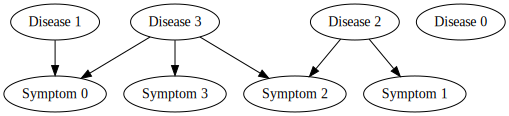

In [542]:
#RUN MEEE :D (for a new graph)
#for fun/help w figure drawing...makes a random net and draws it :)
random_net = MedBayesNet(np.random.randint(10), np.random.randint(10))
graphics = random_net.get_graphics_object()
graphics.draw()

PART 3: DETERMINING CAUSAL LINKS

Now that we have created an appropriate random bayes net generator/source of data, we will make a program that can learn the structure and weights of the disease/symptom network based on the data we feed it. 


In [1240]:
#first we need the MI calculation from the notebook (exploration of causality), adapted to fit our data

import math
def calculate_MI_overall(observations, i_d, i_s):
    #assumes data is of the form [[causes][effects]] i.e. [[diseases][symptoms]]
    N_c_e = 1e-10 #+cause, +effect
    N_nc_ne = 1e-10 #-cause, -effect
    N_c_ne = 1e-10 #cause,-effect
    N_nc_e = 1e-10 #-cause, +effect
    total = len(observations)
    
    for p_ind in range(len(observations)):
        c = observations[p_ind][0][i_d]
        e = observations[p_ind][1][i_s]
        #print(c,e)
        if c == 1 and e == 1:
            N_c_e +=1
        elif c == 0 and e == 0:
            N_nc_ne +=1
        elif c == 1 and e == 0:
            N_c_ne +=1
        elif c == 0 and e == 1:
            N_nc_e +=1
            
    N_e = N_c_e + N_nc_e  #+effect
    N_c = N_c_e + N_c_ne #+cause
    
    def get_contribution(total, N_x_y, N_x, N_y):
        P_joint = N_x_y/total
        #print(N_x/total, "marg comp", N_y/total)
        P_marg = N_x/total*N_y/total
        #print("joint", P_joint, "marginal", P_marg)
        
        #account for 0 cases
        if P_joint == 0.0:
            return 0
        if P_marg <= 0.0:
            P_marg = 1e-10
            
        #print("P_marg", P_marg)
        output = P_joint*(math.log2(P_joint/P_marg))
        #print("output", output)
        return output
    
    #print(N_c_e, N_c_e, N_nc_ne, N_c_ne, N_nc_e)
    #print(N_c, N_e)
    #calculate sum from each of x,y !x,y, x,!y, and !x,!y
    mutual_information = get_contribution(total, N_c_e, N_e, N_c) \
    +get_contribution(total, N_nc_e, N_e, total-N_c) \
    +get_contribution(total, N_c_ne, total-N_e, N_c) \
    +get_contribution(total, N_nc_ne, total-N_e, total-N_c)
    
    #case where the 0 approx gets us into trouble
    if mutual_information <= 0:
        mutual_information = 0
    
    return mutual_information

def calculate_MI_noisyOR(observations, i_d, i_s):
    #assumes data is of the form [[causes][effects]] i.e. [[diseases][symptoms]]
    N_c_e = 1e-10 #+cause, +effect
    N_nc_ne = 1e-10 #-cause, -effect
    N_c_ne = 1e-10 #cause,-effect
    N_nc_e = 1e-10 #-cause, +effect
    total = len(observations)
    
    for p_ind in range(len(observations)):
        c = observations[p_ind][0][i_d]
        e = observations[p_ind][1][i_s]
        #print(c,e)
        if c == 1 and e == 1:
            N_c_e +=1
        elif c == 0 and e == 0:
            N_nc_ne +=1
        elif c == 1 and e == 0:
            N_c_ne +=1
        elif c == 0 and e == 1:
            N_nc_e +=1
            
    N_e = N_c_e + N_nc_e  #+effect
    N_c = N_c_e + N_c_ne #+cause
    
    def get_contribution(total, N_x_y, N_x, N_y):
        P_joint = N_x_y/total
        #print(N_x/total, "marg comp", N_y/total)
        P_marg = N_x/total*N_y/total
        #print("joint", P_joint, "marginal", P_marg)
        
        #account for 0 cases
        if P_joint == 0.0:
            return 0
        if P_marg <= 0.0:
            P_marg = 1e-10
            
        #print("P_marg", P_marg)
        output = P_joint*(math.log2(P_joint/P_marg))
        #print("output", output)
        return output
    
    #print(N_c_e, N_c_e, N_nc_ne, N_c_ne, N_nc_e)
    #print(N_c, N_e)
    #calculate sum from each of x,y !x,y, x,!y, and !x,!y
    mutual_information = get_contribution(total, N_c_e, N_e, N_c)
    
    #case where the 0 approx gets us into trouble

    
    return mutual_information




def causal_power(observations, i_d, i_s):
    #assumes data is of the form [[causes][effects]] i.e. [[diseases][symptoms]]
    N_c_e = 1e-10 #+cause, +effect
    N_nc_ne = 1e-10 #-cause, -effect
    N_c_ne = 1e-10 #cause,-effect
    N_nc_e = 1e-10 #-cause, +effect
    total = len(observations)
    
    for p_ind in range(len(observations)):
        c = observations[p_ind][0][i_d]
        e = observations[p_ind][1][i_s]
        #print(c,e)
        if c == 1 and e == 1:
            N_c_e +=1
        elif c == 0 and e == 0:
            N_nc_ne +=1
        elif c == 1 and e == 0:
            N_c_ne +=1
        elif c == 0 and e == 1:
            N_nc_e +=1
            
    P_e_given_nc = N_nc_e/(N_c_ne+N_nc_ne)     
    #power = delta_p/(1-pos_effect_given_neg_cause)  
    #more causal and less covariational
    return (N_c_e/(N_c_ne+N_c_e)-N_nc_e/(N_c_ne+N_nc_ne))/(1-P_e_given_nc)


def delta_P(observations, i_d, i_s):
    #assumes data is of the form [[causes][effects]] i.e. [[diseases][symptoms]]
    N_c_e = 1e-10 #+cause, +effect
    N_nc_ne = 1e-10 #-cause, -effect
    N_c_ne = 1e-10 #cause,-effect
    N_nc_e = 1e-10 #-cause, +effect
    total = len(observations)
    
    for p_ind in range(len(observations)):
        c = observations[p_ind][0][i_d]
        e = observations[p_ind][1][i_s]
        #print(c,e)
        if c == 1 and e == 1:
            N_c_e +=1
        elif c == 0 and e == 0:
            N_nc_ne +=1
        elif c == 1 and e == 0:
            N_c_ne +=1
        elif c == 0 and e == 1:
            N_nc_e +=1
            
    P_e_given_nc = N_nc_e/(N_c_ne+N_nc_ne)     
    #power = delta_p/(1-pos_effect_given_neg_cause)  
    #more causal and less covariational
    return (N_c_e/(N_c_ne+N_c_e)-N_nc_e/(N_c_ne+N_nc_ne))



In [523]:
def learn_network_structure_MI(data, epsilon = None):
    
    if epsilon == None:
        epsilon = 1/len(data)
    num_diseases = len(data[0][0]) #first data point
    num_symptoms = len(data[0][1])
    print(num_diseases, " diseases", num_symptoms, " symptoms")
    
    disease_connections = {}
    #first, check for mutual information links between diseases and symptoms
    #make a dictionary of symptoms for each disease
    for d in range(num_diseases):
        disease_connections[d] = []
        for s in range(num_symptoms):
            #print(d, s)
            value_MI= calculate_MI_overall(data, d, s)
            #value_OR_MI= calculate_MI_noisyOR(data, d, s)
            value_CP= causal_power(data, d, s)
            print("for disease", d, "and symptom", s, "CP = ", value_CP)
            print("for disease", d, "and symptom", s, "MI = ", value_MI)
            #print("for disease", d, "and symptom", s, "noisyOR_MI = ", value_OR_MI)
            if value_MI > epsilon: 
                disease_connections[d].append(s)
    return disease_connections
                
                


In [568]:
ex_data = sample_from_net(random_net, 100)
learn_network_structure_MI(ex_data)

100%|██████████| 100/100 [00:00<00:00, 4814.90it/s]

4  diseases 4  symptoms
for disease 0 and symptom 0 CP =  0.47368421052601445
for disease 0 and symptom 0 MI =  0.24684964909835125
for disease 0 and symptom 1 CP =  0.2105263157916984
for disease 0 and symptom 1 MI =  0.10121955084099674
for disease 0 and symptom 2 CP =  0.2105263157916984
for disease 0 and symptom 2 MI =  0.10121955084099674
for disease 0 and symptom 3 CP =  4.263157894687704e-12
for disease 0 and symptom 3 MI =  6.4709205235212575e-12
for disease 1 and symptom 0 CP =  0.13636363636378923
for disease 1 and symptom 0 MI =  0.05721025646139002
for disease 1 and symptom 1 CP =  0.06060606060641356
for disease 1 and symptom 1 MI =  0.024593782716990326
for disease 1 and symptom 2 CP =  0.06060606060641356
for disease 1 and symptom 2 MI =  0.024593782716990326
for disease 1 and symptom 3 CP =  5.151515151494388e-13
for disease 1 and symptom 3 MI =  5.926533550316464e-12
for disease 2 and symptom 0 CP =  0.007994186046931565
for disease 2 and symptom 0 MI =  0.011328434880

{0: [0, 1, 2], 1: [0, 1, 2], 2: [0, 1, 2], 3: [1]}

In [539]:
random_net.display_disease_priors()
random_net.display_disease_connections()

0.5336318612098694
0.1944548487663269
0.8883101940155029
0.24234747886657715
0.801480770111084
0.7725164294242859
0 {2: 0.04135596752166748}
1 {}
2 {}
3 {1: 0.34665483236312866, 3: 0.2919524908065796}
4 {3: 0.3786255717277527}
5 {1: 0.3450669050216675, 2: 0.6304187774658203}


In [527]:
sample_from_net(new_random_net, 100)

100%|██████████| 100/100 [00:00<00:00, 2082.73it/s]


[[[1.0, 1.0, 0.0, 1.0], [1.0, 1.0, 1.0, 0.0, 0.0, 0.0]],
 [[1.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
 [[1.0, 0.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0]],
 [[1.0, 1.0, 0.0, 1.0], [1.0, 0.0, 1.0, 1.0, 0.0, 0.0]],
 [[0.0, 0.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
 [[1.0, 0.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0]],
 [[1.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
 [[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0]],
 [[1.0, 1.0, 1.0, 0.0], [1.0, 1.0, 1.0, 1.0, 0.0, 0.0]],
 [[0.0, 0.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
 [[1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0]],
 [[1.0, 1.0, 0.0, 1.0], [1.0, 1.0, 1.0, 0.0, 0.0, 0.0]],
 [[1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
 [[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
 [[1.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
 [[1.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
 [[1.0, 0.0, 1.0, 0.0], [1.0, 0.0, 1.0, 0.0, 0.0, 0.0]],
 [[1.0, 0.0, 0.0, 0.0], [0.0, 0

In [670]:
import pandas as pd
def generate_all_results(num_dis, num_sym):
    #generates 3 sets of objects, for n = 100, 1000, 10000
    #objects are [original graphics object, original_priors + p_values]
    #then for each n [big info table, inferred MI structure graphics object]
    
    #initialize the net
    med_net = MedBayesNet(num_dis, num_sym)
    orig_graphics = med_net.get_graphics_object()
    
   
    priors = med_net.display_disease_priors()
    sym_dict = med_net.display_disease_connections() 
    
    original = [priors, sym_dict]
    
    
   
    #get samples across diff sizes
    s100 = sample_from_net(med_net, 100)
    s1000 = sample_from_net(med_net, 1000)
    s10000 = sample_from_net(med_net, 10000)
    
    
    
    #make a pandas df object containing the info about a sample
    def get_info_summary(sample):
        
        epsilon = 1/len(sample)
      
        all_rows = []
        
        disease_connections ={}
        
        for d in range(num_dis):
    
            disease = med_net.get_disease_object(d)
            disease_connections[d] = []
        
            for s in range(num_sym):

                
                if s in disease.symptom_dict:
                    p_val = disease.symptom_dict[s]
                else:
                    p_val = "NA"
                    
                value_MI = calculate_MI_overall(sample, d, s)
                value_CP = causal_power(sample, d, s)
                value_dP = delta_P(sample, d, s)
                
                struct = 0
                if value_MI > epsilon: 
                    disease_connections[d].append(s)
                    struct = 1
      
                 
                s2 = 0 
                if value_CP > epsilon: 
                    s2 = 1
        
                
                s_row = [d, s, p_val, value_MI, value_CP, value_dP, struct, s2]

                all_rows.append(s_row)

        return (pd.DataFrame(all_rows, columns = ["D", "S", "Original p_val", "MI", "Causal Power", "deltaP", "MI Link", "CP Link"]),\
                disease_connections)
                                          
    (info100, conn100) = get_info_summary(s100)
    (info1000, conn1000) = get_info_summary(s1000)
    (info10000, conn10000) = get_info_summary(s10000)

    # get inferred graphical objects 
    def make_inferred_graphics_object(conn):
        d_strings = []
        s_strings = []
        connections = []
        #make string objects for nodes and edges
        for s in range(num_sym):
            s_str = "Symptom "+str(s)
            s_strings.append(s_str)
            
        for i in range(num_dis):
            d_str = "Disease "+str(i)
            d_strings.append(d_str)
            for sym in conn[i]:
                tup = (d_str, s_strings[sym])
                connections.append(tup)
        #print(connections)
        #print(d_strings + s_strings)
        graphic = CausalGraphicalModel(
        nodes= d_strings + s_strings,
        edges= connections
            )
        return graphic 
    
    return [orig_graphics, original, \
           [info100, make_inferred_graphics_object(conn100)], \
           [info1000, make_inferred_graphics_object(conn1000)], \
           [info10000, make_inferred_graphics_object(conn10000)]]
            
    
        
    
    
    
    

PART 4: RESULTS


Starting from here, run the following cells to generate, sample,
and infer the structure of a randomly-generated bayes net 

In [1229]:
#START HERE

#use these to specify the size of your net 
num_diseases = 4
num_symptoms = 2
#generate results for 3 sample sizes (100, 1000, 10000), display original data 
orig_graph, orig, n100, n1000, n10000 = generate_all_results(num_diseases, num_symptoms) 

  0%|          | 0/10000 [00:00<?, ?it/s]

0.3733167052268982
0.8717514276504517
0.28280383348464966
0.5162818431854248
0 {0: 0.12150448560714722, 1: 0.37914443016052246}
1 {0: 0.9918602108955383}
2 {0: 0.7644745111465454, 1: 0.08564901351928711}
3 {0: 0.5068826079368591, 1: 0.5451251864433289}


100%|██████████| 10000/10000 [00:01<00:00, 5642.93it/s]


In [1230]:
#[dataFrame, graphicsObject] split by number of samples
[df100, g100] = n100
[df1000, g1000] = n1000
[df10000, g10000] = n10000

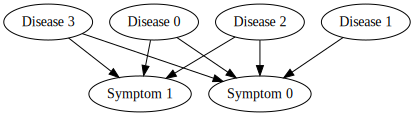

In [1231]:
orig_graph.draw() #original bayes net 

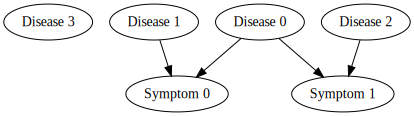

In [1232]:
g1000.draw() #inferred MI bayes net 

In [1233]:
df1000 #dataframe showing stats on each potential causal link (D, S)

,D,S,Original p_val,MI,Causal Power,deltaP,MI Link,CP Link
0,0,0,0.121504,7.568535e-01,0.902813,0.902813,1,1
1,0,1,0.379144,2.830586e-01,0.450128,0.450128,1,1
2,1,0,0.99186,4.244546e-02,0.383528,0.377008,1,1
3,1,1,NA,6.669175e-05,0.154855,0.150720,0,1
4,2,0,0.764475,9.865874e-07,-0.063916,-0.038923,0,0
5,2,1,0.085649,1.025104e-02,0.140473,0.122573,1,1
6,3,0,0.506883,3.988012e-04,0.088239,0.063690,0,1
7,3,1,0.545125,1.725289e-04,0.088943,0.079876,0,1


In [1234]:
orig[0] #prior for the disease nodes

[0.3733167052268982,
 0.8717514276504517,
 0.28280383348464966,
 0.5162818431854248]

In [1235]:
orig[1] #symptom dictionaries of p-values for each node

[{0: 0.12150448560714722, 1: 0.37914443016052246},
 {0: 0.9918602108955383},
 {0: 0.7644745111465454, 1: 0.08564901351928711},
 {0: 0.5068826079368591, 1: 0.5451251864433289}]

In [1236]:
#calculate the % correctness of the structure learning
count = 0
for ind, row in df1000.iterrows():
    if row["Original p_val"] == 'NA' and row["MI Link"] == 1:
        count += 1
    elif row["Original p_val"] != 'NA' and row["MI Link"] == 0:
        count += 1
total = len(df1000.index)
print((total - count)/total*100, "% correct structure learning")


62.5 % correct structure learning


##### 

# 